In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from engine import *
from functools import partial

# 1. a tiny autograd engine (demo)

- micrograd: https://github.com/karpathy/micrograd

In [3]:
def demo():
    a = Value(-4.0)
    b = Value(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
    g.backward()
    print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
    print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

demo()

24.7041
138.8338
645.5773


# 2. calculate gradient automatically

## a) derivative

In [4]:
# f = x^2 - x + 2
def f(x):
    return x**2 - x + 2

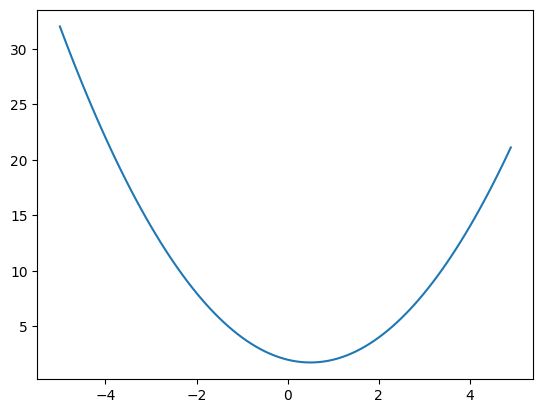

In [5]:
xs = np.arange(-5, 5, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
# manually calculate the derivative: f'(x) = 2*x - 1
# so, if x=2, then f'(2)=3

# Q: how we can calculate this automatically??

In [7]:
# one idea: f'(x) = lim_{h->0} (f(x+h) - f(x)) / h

# here is a numerical approximation
def derivative(f, x):
    h = 0.0000000001
    return (f(x+h)-f(x))/h

In [8]:
derivative(f,2)

3.000000248221113

## b) gradient

In [9]:
# g(a,b) = 2*a + 3*b
def g(a,b):
    return 2*a + 3*b

In [10]:
# manually calculate the gradient wrt (a=3, b=2)
# Q: gradient = [ s]

In [13]:
# auto gradient calculation
def grad(g, av, bv):
    return np.array(
           [derivative(partial(g, b=bv), av),  # for a
            derivative(partial(g, av), bv)]    # for b
           )

In [14]:
grad(g, 2, 3)

array([2.00000017, 3.00000025])

## c) chain rule

In [ ]:
# now, if we have a new function, h

# h = f(g(a,b))
# h = g(a,b)^2 - g(a,b) + 2   [f = x^2 - x + 2]
#   = (2*a + 3*b)^2 - (2*a + 3*b) +2
#                             [g(a,b) = 2*a + 3*b]

# 4a^2 + 12ab + 9b^2 - 2a - 3b +2

# Q: gradient of h(2,3)?
# for a:
#   8a + 12b - 2 =8*2 + 12*3 -2 = 50
# for b:
#   12a + 18b - 3 = 12*2 + 18*3 -3 = 75


In [ ]:
# chain rule:
# h'(a,b) = f'(g(a,b)) * g'(a,b)

# Q: h'(2,3)=?
# f'(g(a,b)) * [2,3] // f'(x) = 2*x - 1
#  =  f'(13) * [2,3] // g(2,3) = 2*2 + 3*3 = 12
#  = 25 * [2,3]
#  = [50,75]


# Q: how to calculate this automatically?

In [15]:
# gradient of h(2,3)
derivative(f, g(2,3)) * grad(g, 2, 3)

array([50.0000438, 75.0000657])

## summary (what we learned)
### 1. we can use a tiny h to numerically calculate deriviate of a function f **automatically** (without understanding f)
### 2. we can calculate gradient **automatically** by using derivative from point 1
### 3. we can **automatically** calculate a sequence of functions by applying chain rule

## What's next?

# 3. autograd for arbitrary functions

## Question:
    
### for a function f(a,b,c) = (a * b) + c,
### how to automatically calculate
    
  $$[\frac{d f(a,b,c)}{da}, \frac{d f(a,b,c)}{db}, \frac{d f(a,b,c)}{dc} ]$$?

In [16]:
# next, we use a pre-defined class: Value

# a bundle of the value and gradient
tmp1 = Value(1.0, label="tmp1")
tmp1

Value(label=tmp1, data=1.0, grad=0)

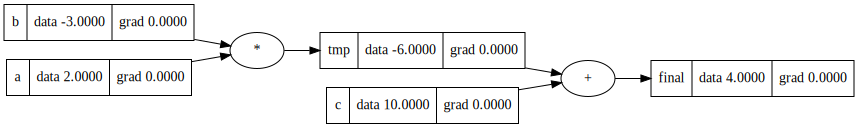

In [17]:
# define a simple function
# f(a,b,c) = a*b + c
def func(av, bv, cv):
    a = Value(av, label='a')
    b = Value(bv, label='b')
    c = Value(cv, label='c')
    tmp = a * b; tmp.label = 'tmp'
    final = tmp + c; final.label = 'final'
    return final

av = 2.0
bv = -3.0
cv = 10.0
L = func(av, bv, cv)
draw_dot(L)

## Next, we will (1) manually, (2) half-auto, and (3) fully auto to calculate the grad for each values

In [18]:
# Q: now focus on "final = tmp + c" for now:
# what is, d final / d c? 
# TODO: calculate by hand
# (should be 1)

# now we can check:
tmp = (av * bv)
derivative(lambda x: tmp + x, cv)

1.000000082740371

In [19]:
# Q: now think of:
#    d final / d b? f(a,b,c) = tmp + c; tmp=a*b
# TODO: calculate by hand
# (should be the value of "a", av=2.0)

# TODO: calculate by chain rule
#   d final / d b = (d final / d tmp) * (d tmp / d b)
# we know d final / d tmp => 1
# what is the d tmp / d b?  (==> value of "a")

# now we can check
1.0 \
  * derivative(lambda x: av*x,
               bv)

2.000000165480742

In [20]:
# Similarly, d final / d a
1.0 \
  * derivative(lambda x: bv*x,
               av)

-3.000000248221113

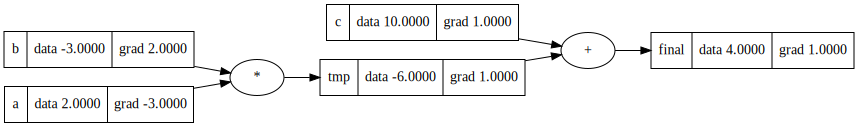

In [21]:
# now fully-atuo way to calcualte grad!!!

L = func(av, bv, cv)
L.backward()
draw_dot(L)

In [ ]:
# Q: how this happens??
#   think as an operator!
# TODO: think as "*"
# TODO: think as "+"

In [ ]:
# how autograd works:
# 1. topological sort the tree:  [a, b, tmp, c, final]
#    and reverse it: [final, c, tmp1, b, a]
# 2. calcualte gradient in this order:
#      final: 1
#      c: think as "+", call "+".backward(): 1
#      tmp1: think as "+", call "+".backward(): 1
#      b: think as "*", call "*".backward(): 2
#      a: think as "*", call "*".backward(): -3


# 4. mirror symmetry input vector problem

In [27]:
import random
    
def sigmoid(x):
    return 1.0 / (1 + (-1.0*x).exp())

class network:
    def __init__(self):
        # weights layer
        self.weights_1 = [Value(random.uniform(-0.3,0.3), label=f"w1[{i}]") for i in range(6)]
        self.weights_2 = [Value(random.uniform(-0.3,0.3), label=f"w2[{i}]") for i in range(6)]
        # bias
        self.bias1, self.bias2, self.bias3 = \
                Value(random.uniform(-0.3,0.3), label="b1"), \
                Value(random.uniform(-0.3,0.3), label="b2"), \
                Value(random.uniform(-0.3,0.3), label="b3")
        # last layer
        self.weights_3a, self.weights_3b = Value(random.uniform(-0.3,0.3), label="w3a"), \
                                           Value(random.uniform(-0.3,0.3), label="w3b")
        # remember all parameters
        self.parameters = []
        self.parameters += self.weights_1
        self.parameters += self.weights_2
        self.parameters += [self.bias1, self.bias2, self.bias3, self.weights_3a, self.weights_3b]
        
    def forward(self, arr):
        assert len(arr) == 6
        act = sigmoid

        # input layer
        xs = []
        for i in range(6):
            assert arr[i] == 0 or arr[i] == 1
            xs.append(Value(arr[i], label=f"x[{i}]"))

        # x*w
        sum1 = sum( [x * w1 for x,w1 in zip(xs, self.weights_1)]); sum1.label="sum1"
        sum2 = sum( [x * w2 for x,w2 in zip(xs, self.weights_2)]); sum2.label="sum2"   

        # calculate hidden
        hidden1 = sum1 + self.bias1; hidden1.label="h1"
        hidden2 = sum2 + self.bias2; hidden2.label="h2"

        # output layer
        tmp = self.weights_3a * act(hidden1) + \
              self.weights_3b * act(hidden2) + self.bias3
        final = act(tmp); final.label="final"

        return final

17


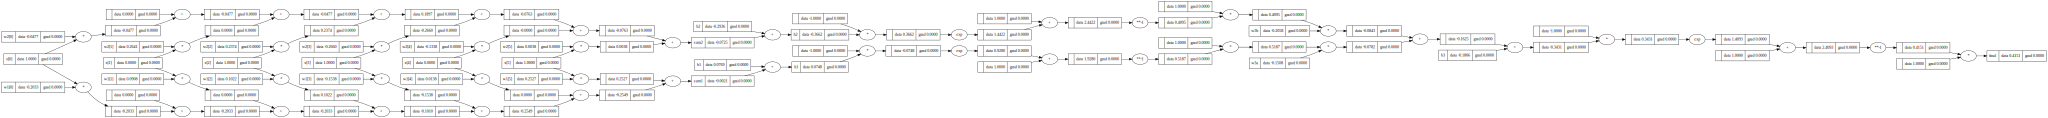

In [28]:
case = [1, 0, 1, 1, 0, 1]

net = network()
L = net.forward(case)
print(len(net.parameters))
draw_dot(L)

In [29]:
# generate training dataset
def gen_dataset():
    dataset = [
        [x1, x2, x3, x4, x5, x6]
        for x1 in [0.0, 1.0]
        for x2 in [0.0, 1.0]
        for x3 in [0.0, 1.0]
        for x4 in [0.0, 1.0]
        for x5 in [0.0, 1.0]
        for x6 in [0.0, 1.0]
    ]
    
    return dataset

def is_sym(arr):
    assert len(arr) == 6
    return 0 if arr[0]==arr[5] and arr[1]==arr[4] and arr[2]==arr[3] else 1
    
xs = gen_dataset()
print(len(xs))
print([ (x,y) for x,y in zip(xs, [is_sym(x) for x in xs])])

64
[([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 0), ([0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 1), ([0.0, 0.0, 0.0, 0.0, 1.0, 0.0], 1), ([0.0, 0.0, 0.0, 0.0, 1.0, 1.0], 1), ([0.0, 0.0, 0.0, 1.0, 0.0, 0.0], 1), ([0.0, 0.0, 0.0, 1.0, 0.0, 1.0], 1), ([0.0, 0.0, 0.0, 1.0, 1.0, 0.0], 1), ([0.0, 0.0, 0.0, 1.0, 1.0, 1.0], 1), ([0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 1), ([0.0, 0.0, 1.0, 0.0, 0.0, 1.0], 1), ([0.0, 0.0, 1.0, 0.0, 1.0, 0.0], 1), ([0.0, 0.0, 1.0, 0.0, 1.0, 1.0], 1), ([0.0, 0.0, 1.0, 1.0, 0.0, 0.0], 0), ([0.0, 0.0, 1.0, 1.0, 0.0, 1.0], 1), ([0.0, 0.0, 1.0, 1.0, 1.0, 0.0], 1), ([0.0, 0.0, 1.0, 1.0, 1.0, 1.0], 1), ([0.0, 1.0, 0.0, 0.0, 0.0, 0.0], 1), ([0.0, 1.0, 0.0, 0.0, 0.0, 1.0], 1), ([0.0, 1.0, 0.0, 0.0, 1.0, 0.0], 0), ([0.0, 1.0, 0.0, 0.0, 1.0, 1.0], 1), ([0.0, 1.0, 0.0, 1.0, 0.0, 0.0], 1), ([0.0, 1.0, 0.0, 1.0, 0.0, 1.0], 1), ([0.0, 1.0, 0.0, 1.0, 1.0, 0.0], 1), ([0.0, 1.0, 0.0, 1.0, 1.0, 1.0], 1), ([0.0, 1.0, 1.0, 0.0, 0.0, 0.0], 1), ([0.0, 1.0, 1.0, 0.0, 0.0, 1.0], 1), ([0.0, 1.0, 1.0, 0.0, 1.0, 0.0], 1

In [30]:
case1=[1,0,1,1,0,1]
case2=[1,0,0,1,0,1]

net = network()
print(net.forward(case1))
print(net.forward(case2))

Value(label=final, data=0.5269142849902796, grad=0)
Value(label=final, data=0.526021661527244, grad=0)


In [38]:
# sgd training!!

learning_rate = 0.05
alpha = 0.0
rounds = 1425
batch_size = 64
net = network()

last_grad = {}
for i in range(rounds):
    # forward pass
    pred_ys = [net.forward(x) for x in xs]

    # loss
    loss = sum([(pred_y - y)**2 for pred_y,y in zip(pred_ys, [is_sym(x) for x in xs])])
    
    # calculate grad
    for p in net.parameters:
        p.grad = 0
    loss.backward()
    
    # gd
    for p in net.parameters:
        delta = -1 * learning_rate * p.grad \
                        + alpha * (0 if p not in last_grad else last_grad[p])
        p.data += delta
        last_grad[p] = delta
    
    print(f"Round[{i}]:  loss = {loss.data}")

Round[0]:  loss = 16.180139910638804
Round[1]:  loss = 8.991713682937972
Round[2]:  loss = 7.756216209417689
Round[3]:  loss = 7.379347459607379
Round[4]:  loss = 7.217586117570233
Round[5]:  loss = 7.135206338735146
Round[6]:  loss = 7.088745540464406
Round[7]:  loss = 7.060710629947903
Round[8]:  loss = 7.0429655875451775
Round[9]:  loss = 7.031328552021288
Round[10]:  loss = 7.023486881358314
Round[11]:  loss = 7.018088352074758
Round[12]:  loss = 7.014307021239469
Round[13]:  loss = 7.01162045942519
Round[14]:  loss = 7.00968868807531
Round[15]:  loss = 7.0082852173993775
Round[16]:  loss = 7.007256191706035
Round[17]:  loss = 7.00649537192795
Round[18]:  loss = 7.00592837792332
Round[19]:  loss = 7.005502519854036
Round[20]:  loss = 7.005180097445947
Round[21]:  loss = 7.004933903463476
Round[22]:  loss = 7.0047441581521035
Round[23]:  loss = 7.004596390140629
Round[24]:  loss = 7.004479953744577
Round[25]:  loss = 7.0043869804776095
Round[26]:  loss = 7.004311630676883
Round[27]:

Round[237]:  loss = 7.001453577298191
Round[238]:  loss = 7.001446376531753
Round[239]:  loss = 7.001439207909932
Round[240]:  loss = 7.001432071246533
Round[241]:  loss = 7.001424966356558
Round[242]:  loss = 7.0014178930562245
Round[243]:  loss = 7.001410851162944
Round[244]:  loss = 7.001403840495312
Round[245]:  loss = 7.001396860873097
Round[246]:  loss = 7.001389912117234
Round[247]:  loss = 7.001382994049827
Round[248]:  loss = 7.001376106494113
Round[249]:  loss = 7.001369249274477
Round[250]:  loss = 7.0013624222164355
Round[251]:  loss = 7.001355625146614
Round[252]:  loss = 7.001348857892767
Round[253]:  loss = 7.001342120283748
Round[254]:  loss = 7.001335412149497
Round[255]:  loss = 7.00132873332105
Round[256]:  loss = 7.001322083630514
Round[257]:  loss = 7.00131546291107
Round[258]:  loss = 7.001308870996964
Round[259]:  loss = 7.001302307723487
Round[260]:  loss = 7.001295772926969
Round[261]:  loss = 7.001289266444795
Round[262]:  loss = 7.001282788115363
Round[263]: 

Round[468]:  loss = 7.000369162952561
Round[469]:  loss = 7.000366116450796
Round[470]:  loss = 7.000363078588809
Round[471]:  loss = 7.0003600493141676
Round[472]:  loss = 7.000357028574675
Round[473]:  loss = 7.0003540163183615
Round[474]:  loss = 7.000351012493475
Round[475]:  loss = 7.000348017048509
Round[476]:  loss = 7.0003450299321575
Round[477]:  loss = 7.00034205109335
Round[478]:  loss = 7.000339080481229
Round[479]:  loss = 7.0003361180451655
Round[480]:  loss = 7.000333163734729
Round[481]:  loss = 7.000330217499725
Round[482]:  loss = 7.000327279290163
Round[483]:  loss = 7.000324349056259
Round[484]:  loss = 7.000321426748465
Round[485]:  loss = 7.000318512317413
Round[486]:  loss = 7.000315605713955
Round[487]:  loss = 7.000312706889162
Round[488]:  loss = 7.00030981579429
Round[489]:  loss = 7.000306932380814
Round[490]:  loss = 7.000304056600402
Round[491]:  loss = 7.000301188404929
Round[492]:  loss = 7.000298327746476
Round[493]:  loss = 7.0002954745773085
Round[494

Round[684]:  loss = 6.999840345901695
Round[685]:  loss = 6.99983821944443
Round[686]:  loss = 6.99983609369221
Round[687]:  loss = 6.999833968617187
Round[688]:  loss = 6.99983184419156
Round[689]:  loss = 6.999829720387538
Round[690]:  loss = 6.999827597177374
Round[691]:  loss = 6.999825474533353
Round[692]:  loss = 6.99982335242778
Round[693]:  loss = 6.99982123083299
Round[694]:  loss = 6.999819109721354
Round[695]:  loss = 6.999816989065256
Round[696]:  loss = 6.9998148688371185
Round[697]:  loss = 6.999812749009394
Round[698]:  loss = 6.999810629554545
Round[699]:  loss = 6.999808510445068
Round[700]:  loss = 6.999806391653485
Round[701]:  loss = 6.999804273152336
Round[702]:  loss = 6.999802154914192
Round[703]:  loss = 6.999800036911642
Round[704]:  loss = 6.999797919117297
Round[705]:  loss = 6.999795801503796
Round[706]:  loss = 6.999793684043788
Round[707]:  loss = 6.999791566709952
Round[708]:  loss = 6.999789449474974
Round[709]:  loss = 6.999787332311582
Round[710]:  los

Round[901]:  loss = 6.9993493598182095
Round[902]:  loss = 6.999346736817654
Round[903]:  loss = 6.99934410828686
Round[904]:  loss = 6.9993414741917475
Round[905]:  loss = 6.999338834498137
Round[906]:  loss = 6.9993361891717605
Round[907]:  loss = 6.999333538178238
Round[908]:  loss = 6.9993308814831146
Round[909]:  loss = 6.9993282190518205
Round[910]:  loss = 6.9993255508497105
Round[911]:  loss = 6.999322876842016
Round[912]:  loss = 6.999320196993886
Round[913]:  loss = 6.999317511270363
Round[914]:  loss = 6.999314819636395
Round[915]:  loss = 6.99931212205682
Round[916]:  loss = 6.999309418496385
Round[917]:  loss = 6.999306708919728
Round[918]:  loss = 6.999303993291381
Round[919]:  loss = 6.999301271575776
Round[920]:  loss = 6.999298543737244
Round[921]:  loss = 6.999295809740005
Round[922]:  loss = 6.99929306954817
Round[923]:  loss = 6.999290323125753
Round[924]:  loss = 6.999287570436653
Round[925]:  loss = 6.999284811444659
Round[926]:  loss = 6.999282046113455
Round[927

Round[1132]:  loss = 6.9985122895243315
Round[1133]:  loss = 6.9985071957418015
Round[1134]:  loss = 6.99850208426068
Round[1135]:  loss = 6.998496954999432
Round[1136]:  loss = 6.998491807876157
Round[1137]:  loss = 6.998486642808602
Round[1138]:  loss = 6.998481459714136
Round[1139]:  loss = 6.998476258509778
Round[1140]:  loss = 6.99847103911217
Round[1141]:  loss = 6.998465801437585
Round[1142]:  loss = 6.998460545401918
Round[1143]:  loss = 6.998455270920703
Round[1144]:  loss = 6.998449977909088
Round[1145]:  loss = 6.998444666281855
Round[1146]:  loss = 6.998439335953392
Round[1147]:  loss = 6.998433986837719
Round[1148]:  loss = 6.9984286188484575
Round[1149]:  loss = 6.9984232318988635
Round[1150]:  loss = 6.998417825901794
Round[1151]:  loss = 6.998412400769718
Round[1152]:  loss = 6.998406956414715
Round[1153]:  loss = 6.998401492748473
Round[1154]:  loss = 6.998396009682281
Round[1155]:  loss = 6.99839050712704
Round[1156]:  loss = 6.99838498499324
Round[1157]:  loss = 6.99

Round[1344]:  loss = 6.996872208756004
Round[1345]:  loss = 6.996860796465171
Round[1346]:  loss = 6.9968493375646315
Round[1347]:  loss = 6.996837831841964
Round[1348]:  loss = 6.996826279083768
Round[1349]:  loss = 6.99681467907573
Round[1350]:  loss = 6.996803031602562
Round[1351]:  loss = 6.9967913364480285
Round[1352]:  loss = 6.996779593394936
Round[1353]:  loss = 6.996767802225122
Round[1354]:  loss = 6.996755962719468
Round[1355]:  loss = 6.996744074657871
Round[1356]:  loss = 6.996732137819267
Round[1357]:  loss = 6.996720151981611
Round[1358]:  loss = 6.996708116921863
Round[1359]:  loss = 6.996696032416026
Round[1360]:  loss = 6.996683898239093
Round[1361]:  loss = 6.9966717141650605
Round[1362]:  loss = 6.996659479966948
Round[1363]:  loss = 6.9966471954167595
Round[1364]:  loss = 6.9966348602855035
Round[1365]:  loss = 6.9966224743431775
Round[1366]:  loss = 6.996610037358769
Round[1367]:  loss = 6.996597549100245
Round[1368]:  loss = 6.996585009334565
Round[1369]:  loss =

In [39]:
case1=[1,0,1,1,0,1]
case2=[1,0,0,1,0,1]

print(net.forward(case1))
print(net.forward(case2))

Value(label=final, data=0.8830337147931616, grad=0)
Value(label=final, data=0.87696031175283, grad=0)


# Appendix: using NNs

In [40]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.relu()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [41]:
case1=[1,0,1,1,0,1]
case2=[1,0,0,1,0,1]

net = MLP(6, [12, 1])
print(net(case1))
print(net(case2))

Value(label=, data=0, grad=0)
Value(label=, data=0, grad=0)


In [42]:
# dataset
xs = gen_dataset()
ys = [is_sym(x) for x in xs]

In [43]:
# train!
net = MLP(6, [12, 8, 1])

for k in range(1000):  
  # forward pass
  ypred = [net(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in net.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in net.parameters():
    p.data += -0.0011 * p.grad
  
  print(k, loss)

0 Value(label=, data=54.499013959026485, grad=1)
1 Value(label=, data=53.90729919570866, grad=1)
2 Value(label=, data=53.178070203609195, grad=1)
3 Value(label=, data=51.26857022994758, grad=1)
4 Value(label=, data=49.67360170454007, grad=1)
5 Value(label=, data=49.42089962015939, grad=1)
6 Value(label=, data=49.26266779510844, grad=1)
7 Value(label=, data=49.13258087833498, grad=1)
8 Value(label=, data=49.01372110485672, grad=1)
9 Value(label=, data=48.90478700514655, grad=1)
10 Value(label=, data=48.80922597833589, grad=1)
11 Value(label=, data=48.72425307643866, grad=1)
12 Value(label=, data=48.632099072883534, grad=1)
13 Value(label=, data=48.298192425685286, grad=1)
14 Value(label=, data=47.35660503425608, grad=1)
15 Value(label=, data=46.220747156373704, grad=1)
16 Value(label=, data=44.65868844842842, grad=1)
17 Value(label=, data=42.33158752333826, grad=1)
18 Value(label=, data=40.53095564447852, grad=1)
19 Value(label=, data=38.76142876634236, grad=1)
20 Value(label=, data=37.

167 Value(label=, data=5.920409067367943, grad=1)
168 Value(label=, data=5.881081986657539, grad=1)
169 Value(label=, data=5.843756083792928, grad=1)
170 Value(label=, data=5.8229262146449265, grad=1)
171 Value(label=, data=5.808233783759492, grad=1)
172 Value(label=, data=5.782776547662163, grad=1)
173 Value(label=, data=5.774822618521501, grad=1)
174 Value(label=, data=5.742613985643688, grad=1)
175 Value(label=, data=5.741247816416743, grad=1)
176 Value(label=, data=5.709727202894866, grad=1)
177 Value(label=, data=5.6766657650624905, grad=1)
178 Value(label=, data=5.657485766125188, grad=1)
179 Value(label=, data=5.648265879109563, grad=1)
180 Value(label=, data=5.62178693950226, grad=1)
181 Value(label=, data=5.620655126986324, grad=1)
182 Value(label=, data=5.591809877906849, grad=1)
183 Value(label=, data=5.563360764191597, grad=1)
184 Value(label=, data=5.546154003121125, grad=1)
185 Value(label=, data=5.539296963911584, grad=1)
186 Value(label=, data=5.513989363983633, grad=1)

331 Value(label=, data=4.638022873668204, grad=1)
332 Value(label=, data=4.727383999530208, grad=1)
333 Value(label=, data=4.636814031021503, grad=1)
334 Value(label=, data=4.723446591340771, grad=1)
335 Value(label=, data=4.626666890074594, grad=1)
336 Value(label=, data=4.612909236465749, grad=1)
337 Value(label=, data=4.593186700675583, grad=1)
338 Value(label=, data=4.650719512356403, grad=1)
339 Value(label=, data=4.6049581938947854, grad=1)
340 Value(label=, data=4.722139286665448, grad=1)
341 Value(label=, data=4.698984990563723, grad=1)
342 Value(label=, data=4.816038363003391, grad=1)
343 Value(label=, data=4.779189685028975, grad=1)
344 Value(label=, data=4.892997710531947, grad=1)
345 Value(label=, data=4.840344712892134, grad=1)
346 Value(label=, data=4.940957237734527, grad=1)
347 Value(label=, data=4.881006108426114, grad=1)
348 Value(label=, data=4.985757638121489, grad=1)
349 Value(label=, data=4.90840903590441, grad=1)
350 Value(label=, data=4.996496630996441, grad=1)


495 Value(label=, data=3.957461765312198, grad=1)
496 Value(label=, data=4.000617909816552, grad=1)
497 Value(label=, data=3.938955669450041, grad=1)
498 Value(label=, data=4.026260603693945, grad=1)
499 Value(label=, data=3.9400704852874, grad=1)
500 Value(label=, data=3.995920309232343, grad=1)
501 Value(label=, data=3.9285194115925264, grad=1)
502 Value(label=, data=4.009398840357851, grad=1)
503 Value(label=, data=3.9335952548554456, grad=1)
504 Value(label=, data=4.037166644330604, grad=1)
505 Value(label=, data=3.999386746864793, grad=1)
506 Value(label=, data=4.059438408121342, grad=1)
507 Value(label=, data=3.973703634877492, grad=1)
508 Value(label=, data=4.064644970646479, grad=1)
509 Value(label=, data=4.023883919545822, grad=1)
510 Value(label=, data=4.097101309896224, grad=1)
511 Value(label=, data=3.9955078305947853, grad=1)
512 Value(label=, data=4.088245556663492, grad=1)
513 Value(label=, data=3.9739135765805056, grad=1)
514 Value(label=, data=4.007981888136469, grad=1

658 Value(label=, data=3.6398407424523755, grad=1)
659 Value(label=, data=3.6337178501702616, grad=1)
660 Value(label=, data=3.678990376211432, grad=1)
661 Value(label=, data=3.641584212307677, grad=1)
662 Value(label=, data=3.6994182207340116, grad=1)
663 Value(label=, data=3.6574798482183644, grad=1)
664 Value(label=, data=3.704658906268305, grad=1)
665 Value(label=, data=3.637256468567, grad=1)
666 Value(label=, data=3.6950688969391963, grad=1)
667 Value(label=, data=3.6857063958881056, grad=1)
668 Value(label=, data=3.713305924831767, grad=1)
669 Value(label=, data=3.625301404634406, grad=1)
670 Value(label=, data=3.6933502981374717, grad=1)
671 Value(label=, data=3.6727386774632267, grad=1)
672 Value(label=, data=3.7040662975302636, grad=1)
673 Value(label=, data=3.646860375421812, grad=1)
674 Value(label=, data=3.6969887590474935, grad=1)
675 Value(label=, data=3.661446213901675, grad=1)
676 Value(label=, data=3.7091148492478254, grad=1)
677 Value(label=, data=3.658078359317026, 

822 Value(label=, data=3.4347950170633563, grad=1)
823 Value(label=, data=3.4003724206934085, grad=1)
824 Value(label=, data=3.472926728056696, grad=1)
825 Value(label=, data=3.398352460098577, grad=1)
826 Value(label=, data=3.476039361928021, grad=1)
827 Value(label=, data=3.42464232931009, grad=1)
828 Value(label=, data=3.5011192627681336, grad=1)
829 Value(label=, data=3.4368233659055396, grad=1)
830 Value(label=, data=3.4984823516888497, grad=1)
831 Value(label=, data=3.4875171704290153, grad=1)
832 Value(label=, data=3.5514436729410885, grad=1)
833 Value(label=, data=3.486205309810545, grad=1)
834 Value(label=, data=3.5434845529632697, grad=1)
835 Value(label=, data=3.482486628866404, grad=1)
836 Value(label=, data=3.529671589379526, grad=1)
837 Value(label=, data=3.456757716034201, grad=1)
838 Value(label=, data=3.5229713960225193, grad=1)
839 Value(label=, data=3.444117572224663, grad=1)
840 Value(label=, data=3.4954902302747963, grad=1)
841 Value(label=, data=3.424673742888883,

985 Value(label=, data=3.148045927655264, grad=1)
986 Value(label=, data=3.253817110172518, grad=1)
987 Value(label=, data=3.1663902315282053, grad=1)
988 Value(label=, data=3.262225496605134, grad=1)
989 Value(label=, data=3.1569256047263736, grad=1)
990 Value(label=, data=3.2656624812850303, grad=1)
991 Value(label=, data=3.1552015625163174, grad=1)
992 Value(label=, data=3.2402936477296995, grad=1)
993 Value(label=, data=3.1474525439483707, grad=1)
994 Value(label=, data=3.241801885037714, grad=1)
995 Value(label=, data=3.13718157786161, grad=1)
996 Value(label=, data=3.246425441736938, grad=1)
997 Value(label=, data=3.1499901225450224, grad=1)
998 Value(label=, data=3.233019013488694, grad=1)
999 Value(label=, data=3.129622228973346, grad=1)


In [44]:
case1=[1,0,1,1,0,1]
case2=[1,0,0,1,0,1]

print(net(case1))
print(net(case2))

Value(label=, data=0.4436612612473406, grad=0)
Value(label=, data=0.7152044957343813, grad=0)
